# Auto-Regressive Models

## Introduction

In this notebook, I explore three foundational autoregressive models:

1. **Fully Visible Sigmoid Belief Network (FVSBN)**
2. **Neural Autoregressive Distribution Estimation (NADE)**
3. **Masked Autoencoder for Distribution Estimation (MADE)**

We will understand and train each of these models on the **binarized MNIST dataset** and analyze their performance.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns
from tqdm import tqdm

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load MNIST dataset
def binarize(x):
    return torch.bernoulli(x)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize)
])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
                                         transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        transform=transform, download=True)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

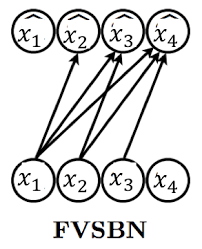

In [18]:
from IPython.display import Image

# Display the image
Image("/kaggle/input/early-regg/download (1).png")


## Fully Visible Sigmoid Belief Network (FVSBN)

The **Fully Visible Sigmoid Belief Network (FVSBN)** is an autoregressive probabilistic model that factorizes the joint distribution of a binary dataset into a sequence of conditional probabilities. Each variable is modeled as a Bernoulli distribution, conditioned on the previous variables.

### Key Properties:
- The probability of each binary variable \( x_i \) is computed as:
$$
P(x_i | x_1, ..., x_{i-1}) = σ(w_i^T x_{1:i-1} + b_i)
$$
  where $( \sigma(z) = \frac{1}{1 + \exp(-z)} )$ is the sigmoid activation function, $( w_i )$ is a weight vector, and $( b_i )$ is a bias term.

- The model is **fully visible**, meaning it does not have hidden layers.
- It captures dependencies between pixels in a sequential manner.
- Training is typically done via maximum likelihood estimation (MLE).

### Advantages:
- Simple and interpretable.
- Exact likelihood computation is possible.
- Can model complex dependencies in binary data.

### Limitations:
- Inefficient for large-scale datasets due to sequential dependency modeling.
- Cannot capture hierarchical representations like deep neural networks.


In [5]:
class FVSBN(nn.Module):
    def __init__(self, input_size):
        super(FVSBN, self).__init__()
        self.input_size = input_size
        # Lower triangular weight matrix to ensure regressivness,
        # that each pixel only depends on the previous ones only
        self.W = nn.Parameter(torch.zeros(input_size, input_size))
        self.b = nn.Parameter(torch.zeros(input_size))
        
    def forward(self, x):
        batch_size = x.size(0)
        # Create mask for lower triangular matrix
        mask = torch.tril(torch.ones_like(self.W), diagonal=-1)
        W_masked = self.W * mask
        
        # Compute log probabilities
        logits = self.b + torch.matmul(x, W_masked)
        probs = torch.sigmoid(logits)
        
        # Compute log likelihood
        log_probs = x * torch.log(probs + 1e-8) + (1 - x) * torch.log(1 - probs + 1e-8)
        return log_probs
    
    def sample(self, num_samples):
        samples = torch.zeros(num_samples, self.input_size, device=device)
        
        # Generate samples one dimension at a time
        for i in range(self.input_size):
            mask = torch.tril(torch.ones_like(self.W), diagonal=-1)
            W_masked = self.W * mask
            logits = self.b[i] + torch.matmul(samples, W_masked[i])
            probs = torch.sigmoid(logits)
            samples[:, i] = torch.bernoulli(probs)
            
        return samples


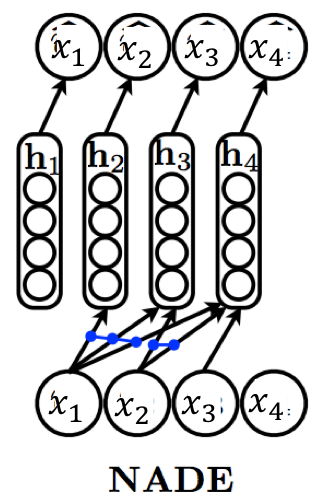

In [20]:
from IPython.display import Image

# Display the image
Image("/kaggle/input/early-regg/nade.png")


## Neural Autoregressive Distribution Estimation (NADE)

The **Neural Autoregressive Distribution Estimation (NADE)** is a model designed to estimate the joint distribution of a set of binary variables. Unlike traditional models that compute the joint distribution directly, NADE decomposes it into a series of conditional distributions, making it computationally feasible to train and generate data in high-dimensional spaces.

### Key Idea:
NADE uses a neural network to model the conditional distribution of each variable, conditioned on the previous variables. The joint distribution is factorized as a product of conditional probabilities:

$$
P(x_1, x_2, ..., x_n) = \prod_{i=1}^{n} P(x_i | x_1, x_2, ..., x_{i-1})
$$

This factorization allows the model to predict each variable sequentially, making it autoregressive.

### Model Structure:
- The model consists of a neural network that takes as input the values of the previous variables $( x_1, x_2, ..., x_{i-1}) $ and outputs the parameters of the conditional probability distribution for $( x_i )$.
- The conditional probability is typically modeled as a Bernoulli distribution with a probability $( \sigma(z_i) )$, where $( \sigma )$ is the sigmoid activation function, and $( z_i )$ is the output of the neural network for variable $( x_i )$.

$$
P(x_i | x_1, x_2, ..., x_{i-1}) = \sigma(w_i^T h_{i-1} + b_i)
$$

where:
- $( w_i )$ is a weight vector,
- $( h_{i-1} $) is the hidden state of the network, which is computed from the previous variables,
- $( b_i )$ is a bias term,
- $( \sigma(z) = \frac{1}{1 + \exp(-z)} )$ is the sigmoid function.

### Training:
The model is trained by maximizing the likelihood of the observed data. The log-likelihood of the data is:

$$
\log P(x_1, x_2, ..., x_n) = \sum_{i=1}^{n} \log P(x_i | x_1, x_2, ..., x_{i-1})
$$

During training, we aim to find the parameters of the neural network that maximize the log-likelihood of the data.

### Advantages:
- NADE provides an efficient way to model high-dimensional binary data by decomposing the joint distribution into manageable conditional distributions.
- The model is flexible and can be extended to more complex data distributions.

### Limitations:
- Like other autoregressive models, NADE has to process data sequentially, which can be computationally expensive for large datasets.
- It is prone to overfitting when the model is too complex relative to the amount of data.


In [6]:
class NADE(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NADE, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Parameters for hidden layer
        self.W = nn.Parameter(torch.randn(input_size, hidden_size) / np.sqrt(input_size))
        self.c = nn.Parameter(torch.zeros(hidden_size))
        
        # Parameters for output layer
        self.V = nn.Parameter(torch.randn(hidden_size, input_size) / np.sqrt(hidden_size))
        self.b = nn.Parameter(torch.zeros(input_size))
        
    def forward(self, x):
        batch_size = x.size(0)
        log_probs = torch.zeros(batch_size, self.input_size, device=device)
        
        # Initialize a mask for the hidden units
        a = torch.zeros(batch_size, self.hidden_size, device=device)
        
        # Process each dimension
        for i in range(self.input_size):
            # Compute hidden units
            h = torch.sigmoid(a + self.c)
            
            # Compute probability of current dimension
            logit = torch.matmul(h, self.V[:, i]) + self.b[i]
            prob = torch.sigmoid(logit)
            
            # Store log probability
            log_probs[:, i] = x[:, i] * torch.log(prob + 1e-8) + \
                             (1 - x[:, i]) * torch.log(1 - prob + 1e-8)
            
            # Update a for next iteration
            if i < self.input_size - 1:
                a = a + torch.outer(x[:, i], self.W[i, :])
        
        return log_probs
    
    def sample(self, num_samples):
        samples = torch.zeros(num_samples, self.input_size, device=device)
        
        # Initialize hidden activation
        a = torch.zeros(num_samples, self.hidden_size, device=device)
        
        # Generate samples one dimension at a time
        for i in range(self.input_size):
            h = torch.sigmoid(a + self.c)
            logit = torch.matmul(h, self.V[:, i]) + self.b[i]
            prob = torch.sigmoid(logit)
            
            # Sample current dimension
            samples[:, i] = torch.bernoulli(prob)
            
            # Update hidden activation
            if i < self.input_size - 1:
                a = a + torch.outer(samples[:, i], self.W[i, :])
        
        return samples


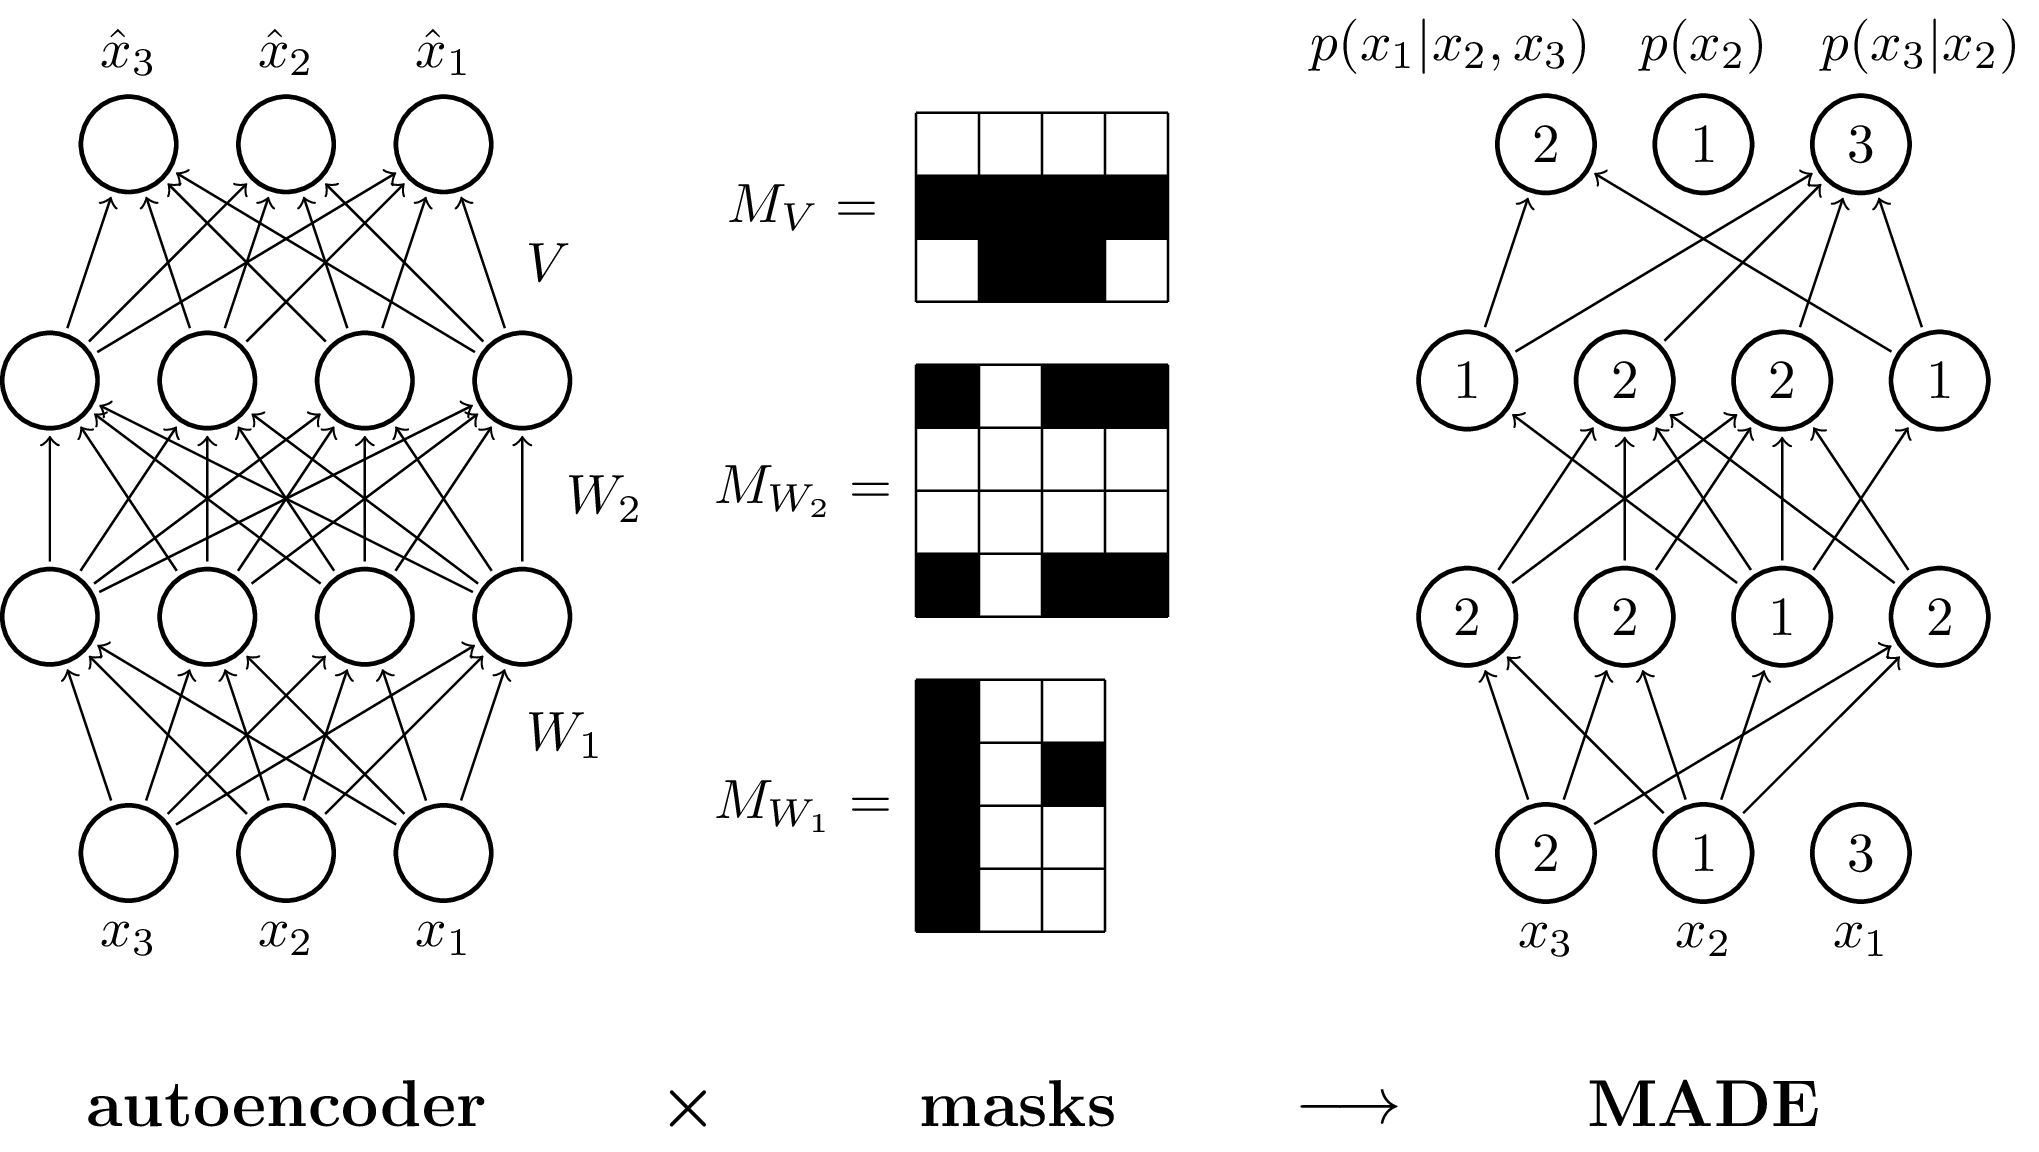

In [21]:
from IPython.display import Image

# Display the image
Image("/kaggle/input/early-regg/made.png")


## Masked Autoencoder for Distribution Estimation (MADE)

The **Masked Autoencoder for Distribution Estimation (MADE)** is a model designed to estimate complex high-dimensional probability distributions. It combines ideas from autoencoders and autoregressive models to enable efficient training of generative models for large-scale data. MADE uses masked autoencoders to ensure that each variable is predicted in a causal, autoregressive manner, similar to other autoregressive models.

### Key Idea:
MADE improves upon standard autoregressive models by introducing **masking** in the connections between the layers. The key idea is to mask the weights of the model such that each variable $( x_i )$ is only dependent on the previous variables, preserving the autoregressive structure. This approach enables parallelization during both training and sampling, making the model more efficient.

### Masked Weight Matrix:
In MADE, the weight matrix is masked so that each variable only depends on previous variables. The weight matrix is structured to ensure that each node in the network is influenced only by the nodes that precede it. This is achieved by applying a mask to the weight matrix, where each connection between variables is either allowed (unmasked) or blocked (masked).

The masked weight matrix \( W \) has a lower triangular structure with additional masked connections. For instance, the weight matrix for a model with \( n \) variables can be represented as:

$$
W = \begin{pmatrix}
w_{1,1} & 0 & 0 & \dots & 0 \\
w_{2,1} & w_{2,2} & 0 & \dots & 0 \\
w_{3,1} & w_{3,2} & w_{3,3} & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
w_{n,1} & w_{n,2} & w_{n,3} & \dots & w_{n,n}
\end{pmatrix}
$$

where the connections are masked such that each \( x_i \) only depends on \( x_1, x_2, ..., x_{i-1} \).

### Model Structure:
1. **Autoencoder Architecture**: The MADE model uses an autoencoder architecture, where the encoder maps the input variables to a latent space, and the decoder maps the latent space back to the distribution over the variables.
2. **Masked Connections**: The key idea is to mask the connections in the encoder and decoder so that each variable is only influenced by the previous variables in the sequence.

The output for each variable \( x_i \) is computed as:

$$
P(x_i | x_1, x_2, ..., x_{i-1}) = \sigma(W_i^T h_{i-1} + b_i)
$$

where:
- \( W_i \) is the masked weight matrix for variable \( x_i \),
- \( h_{i-1} \) is the hidden state from the previous variables,
- \( b_i \) is the bias term for variable \( x_i \),
- \( \sigma(z) = \frac{1}{1 + \exp(-z)} \) is the sigmoid function.

### Training:
The model is trained by maximizing the log-likelihood of the data, similar to other autoregressive models. The log-likelihood is given by:

$$
\log P(x_1, x_2, ..., x_n) = \sum_{i=1}^{n} \log P(x_i | x_1, x_2, ..., x_{i-1})
$$

During training, we optimize the model parameters to maximize the likelihood of the data.

### Advantages:
- **Parallelization**: Unlike other autoregressive models, MADE allows for efficient parallel training and sampling because of the masking mechanism. This makes it more scalable than traditional autoregressive models.
- **Flexibility**: MADE can be applied to various types of data and is flexible enough to model complex high-dimensional distributions.

### Limitations:
- **Model Complexity**: The complexity of the mask design can make the model harder to tune and train effectively.
- **Overfitting**: Like other deep learning models, MADE can be prone to overfitting if the model is too complex for the available data.


In [12]:
class MADE(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MADE, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        
        # Create masks for each layer
        self.masks = self.create_masks()
        
        # Create layers
        layers = []
        prev_size = input_size
        for size in hidden_sizes:
            layers.append(MaskedLinear(prev_size, size, self.masks.pop(0)))
            layers.append(nn.ReLU())
            prev_size = size
        
        # Output layer (single output per input dimension for binary data)
        self.output_layer = MaskedLinear(prev_size, input_size, self.masks.pop(0))
        
        self.net = nn.Sequential(*layers)
        
    def create_masks(self):
        masks = []
        
        # Create ordering of input dimensions
        ordering = torch.arange(self.input_size)
        
        # Create masks for hidden layers
        prev_degrees = ordering
        for size in self.hidden_sizes:
            degrees = torch.arange(size) % (self.input_size - 1)
            mask = (degrees.unsqueeze(1) >= prev_degrees.unsqueeze(0)).float()
            masks.append(mask)
            prev_degrees = degrees
            
        # Create mask for output layer (single output per dimension)
        mask = (ordering.unsqueeze(1) > prev_degrees.unsqueeze(0)).float()
        masks.append(mask)
        
        return masks
    
    def forward(self, x):
        # Pass through network
        h = self.net(x)
        logits = self.output_layer(h)
        
        # Compute probabilities
        probs = torch.sigmoid(logits)
        
        # Compute log probabilities for binary data
        log_probs = x * torch.log(probs + 1e-8) + (1 - x) * torch.log(1 - probs + 1e-8)
        
        return log_probs
    
    def sample(self, num_samples):
        samples = torch.zeros(num_samples, self.input_size, device=device)
        
        # Generate samples one dimension at a time
        for i in range(self.input_size):
            h = self.net(samples)
            logits = self.output_layer(h)
            probs = torch.sigmoid(logits[:, i])
            
            # Sample from Bernoulli distribution
            samples[:, i] = torch.bernoulli(probs)
        
        return samples

In [8]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__(in_features, out_features)
        self.register_buffer('mask', mask)
        
    def forward(self, x):
        return nn.functional.linear(x, self.weight * self.mask, self.bias)

## Comparison of FVSBN, NADE, and MADE

The three models — **Fully Visible Sigmoid Belief Network (FVSBN)**, **Neural Autoregressive Distribution Estimation (NADE)**, and **Masked Autoencoder for Distribution Estimation (MADE)** — are all autoregressive models designed to estimate complex distributions, but they differ in their structures and approaches:

### 1. Fully Visible Sigmoid Belief Network (FVSBN):
- **Key Idea**: FVSBN uses a fully visible directed acyclic graph (DAG) with binary variables and conditional dependencies. It models the joint distribution of all variables by factorizing it into a product of conditional distributions.
- **Architecture**: The model uses a layer of binary hidden units and visible units, with weights that are shared across all nodes.
- **Difference**: Unlike the other two models, FVSBN focuses on a fully visible network where all hidden units are visible to the model, requiring a more complex inference process.

### 2. Neural Autoregressive Distribution Estimation (NADE):
- **Key Idea**: NADE factorizes the joint distribution of binary variables into a product of conditional distributions, but each variable is conditioned on the previous ones.
- **Architecture**: It uses a feedforward neural network where the input to the network is conditioned on the previously predicted variables. The output gives the conditional probability for each variable.
- **Difference**: NADE is autoregressive, meaning it predicts each variable sequentially based on the previous ones. This allows for more efficient modeling compared to FVSBN.

### 3. Masked Autoencoder for Distribution Estimation (MADE):
- **Key Idea**: MADE extends NADE by introducing masking to the weight matrices, which makes the model more efficient in training and generation. It ensures that each variable is only dependent on previous ones in a causal manner.
- **Architecture**: The model uses an autoencoder architecture with masked weights to ensure the autoregressive structure. It allows for efficient parallelization during training and sampling.
- **Difference**: The key difference is the masking of weights, which allows for parallelism and reduces training time. Unlike NADE, MADE can be trained more efficiently and handles larger datasets more effectively.

### Summary:
- **FVSBN**: Focuses on fully visible binary networks but is computationally complex.
- **NADE**: Uses a simple autoregressive structure to model conditional distributions sequentially.
- **MADE**: Enhances NADE by using masked weights to enable parallel training and more efficient sampling.


In [9]:
def train_model(model, train_loader, test_loader, optimizer, epochs):
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
            data = data.view(-1, 784).to(device)
            optimizer.zero_grad()
            
            log_probs = model(data)
            loss = -log_probs.mean()
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Testing
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.view(-1, 784).to(device)
                log_probs = model(data)
                loss = -log_probs.mean()
                test_loss += loss.item()
                
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}')
    
    return train_losses, test_losses

In [10]:
# Train FVSBN
fvsbn = FVSBN(784).to(device)
fvsbn_optimizer = optim.Adam(fvsbn.parameters(), lr=0.001)
fvsbn_train_losses, fvsbn_test_losses = train_model(fvsbn, train_loader, test_loader, 
                                                   fvsbn_optimizer, epochs=20)

100%|██████████| 469/469 [00:08<00:00, 56.03it/s]


Epoch 1: Train Loss = 0.3190, Test Loss = 0.2531


100%|██████████| 469/469 [00:07<00:00, 59.25it/s]


Epoch 2: Train Loss = 0.2309, Test Loss = 0.2104


100%|██████████| 469/469 [00:07<00:00, 59.74it/s]


Epoch 3: Train Loss = 0.1989, Test Loss = 0.1861


100%|██████████| 469/469 [00:08<00:00, 58.55it/s]


Epoch 4: Train Loss = 0.1790, Test Loss = 0.1700


100%|██████████| 469/469 [00:07<00:00, 59.83it/s]


Epoch 5: Train Loss = 0.1656, Test Loss = 0.1590


100%|██████████| 469/469 [00:07<00:00, 59.91it/s]


Epoch 6: Train Loss = 0.1559, Test Loss = 0.1506


100%|██████████| 469/469 [00:07<00:00, 59.72it/s]


Epoch 7: Train Loss = 0.1489, Test Loss = 0.1449


100%|██████████| 469/469 [00:07<00:00, 58.94it/s]


Epoch 8: Train Loss = 0.1437, Test Loss = 0.1403


100%|██████████| 469/469 [00:07<00:00, 59.55it/s]


Epoch 9: Train Loss = 0.1398, Test Loss = 0.1370


100%|██████████| 469/469 [00:07<00:00, 59.57it/s]


Epoch 10: Train Loss = 0.1367, Test Loss = 0.1343


100%|██████████| 469/469 [00:07<00:00, 59.48it/s]


Epoch 11: Train Loss = 0.1344, Test Loss = 0.1323


100%|██████████| 469/469 [00:07<00:00, 59.73it/s]


Epoch 12: Train Loss = 0.1325, Test Loss = 0.1305


100%|██████████| 469/469 [00:07<00:00, 59.86it/s]


Epoch 13: Train Loss = 0.1310, Test Loss = 0.1292


100%|██████████| 469/469 [00:07<00:00, 59.92it/s]


Epoch 14: Train Loss = 0.1299, Test Loss = 0.1283


100%|██████████| 469/469 [00:07<00:00, 59.35it/s]


Epoch 15: Train Loss = 0.1289, Test Loss = 0.1274


100%|██████████| 469/469 [00:07<00:00, 59.99it/s]


Epoch 16: Train Loss = 0.1281, Test Loss = 0.1267


100%|██████████| 469/469 [00:07<00:00, 60.31it/s]


Epoch 17: Train Loss = 0.1276, Test Loss = 0.1260


100%|██████████| 469/469 [00:07<00:00, 60.17it/s]


Epoch 18: Train Loss = 0.1270, Test Loss = 0.1258


100%|██████████| 469/469 [00:07<00:00, 60.90it/s]


Epoch 19: Train Loss = 0.1266, Test Loss = 0.1254


100%|██████████| 469/469 [00:07<00:00, 60.50it/s]


Epoch 20: Train Loss = 0.1263, Test Loss = 0.1250


In [11]:
nade = NADE(784, hidden_size=500).to(device)
nade_optimizer = optim.Adam(nade.parameters(), lr=0.001)
nade_train_losses, nade_test_losses = train_model(nade, train_loader, test_loader, 
                                                 nade_optimizer, epochs=20)

100%|██████████| 469/469 [05:40<00:00,  1.38it/s]


Epoch 1: Train Loss = 0.1992, Test Loss = 0.1541


100%|██████████| 469/469 [05:44<00:00,  1.36it/s]


Epoch 2: Train Loss = 0.1443, Test Loss = 0.1350


100%|██████████| 469/469 [05:47<00:00,  1.35it/s]


Epoch 3: Train Loss = 0.1325, Test Loss = 0.1278


100%|██████████| 469/469 [05:46<00:00,  1.35it/s]


Epoch 4: Train Loss = 0.1271, Test Loss = 0.1239


100%|██████████| 469/469 [05:44<00:00,  1.36it/s]


Epoch 5: Train Loss = 0.1240, Test Loss = 0.1216


100%|██████████| 469/469 [05:44<00:00,  1.36it/s]


Epoch 6: Train Loss = 0.1219, Test Loss = 0.1201


100%|██████████| 469/469 [05:43<00:00,  1.37it/s]


Epoch 7: Train Loss = 0.1203, Test Loss = 0.1187


100%|██████████| 469/469 [05:45<00:00,  1.36it/s]


Epoch 8: Train Loss = 0.1191, Test Loss = 0.1177


100%|██████████| 469/469 [05:45<00:00,  1.36it/s]


Epoch 9: Train Loss = 0.1180, Test Loss = 0.1166


100%|██████████| 469/469 [05:41<00:00,  1.37it/s]


Epoch 10: Train Loss = 0.1171, Test Loss = 0.1159


100%|██████████| 469/469 [05:38<00:00,  1.39it/s]


Epoch 11: Train Loss = 0.1164, Test Loss = 0.1155


100%|██████████| 469/469 [05:39<00:00,  1.38it/s]


Epoch 12: Train Loss = 0.1158, Test Loss = 0.1147


100%|██████████| 469/469 [05:38<00:00,  1.38it/s]


Epoch 13: Train Loss = 0.1152, Test Loss = 0.1143


100%|██████████| 469/469 [05:39<00:00,  1.38it/s]


Epoch 14: Train Loss = 0.1147, Test Loss = 0.1138


100%|██████████| 469/469 [05:38<00:00,  1.38it/s]


Epoch 15: Train Loss = 0.1143, Test Loss = 0.1136


100%|██████████| 469/469 [05:39<00:00,  1.38it/s]


Epoch 16: Train Loss = 0.1138, Test Loss = 0.1135


100%|██████████| 469/469 [05:39<00:00,  1.38it/s]


Epoch 17: Train Loss = 0.1135, Test Loss = 0.1129


100%|██████████| 469/469 [05:39<00:00,  1.38it/s]


Epoch 18: Train Loss = 0.1132, Test Loss = 0.1125


100%|██████████| 469/469 [05:41<00:00,  1.37it/s]


Epoch 19: Train Loss = 0.1129, Test Loss = 0.1125


100%|██████████| 469/469 [05:38<00:00,  1.38it/s]


Epoch 20: Train Loss = 0.1126, Test Loss = 0.1121


In [13]:
made = MADE(784, hidden_sizes=[500, 500]).to(device)
made_optimizer = optim.Adam(made.parameters(), lr=0.001)
made_train_losses, made_test_losses = train_model(made, train_loader, test_loader, 
                                                 made_optimizer, epochs=20)

100%|██████████| 469/469 [00:07<00:00, 59.72it/s]


Epoch 1: Train Loss = 0.2701, Test Loss = 0.2050


100%|██████████| 469/469 [00:07<00:00, 58.67it/s]


Epoch 2: Train Loss = 0.1884, Test Loss = 0.1751


100%|██████████| 469/469 [00:08<00:00, 58.35it/s]


Epoch 3: Train Loss = 0.1700, Test Loss = 0.1638


100%|██████████| 469/469 [00:08<00:00, 57.93it/s]


Epoch 4: Train Loss = 0.1620, Test Loss = 0.1581


100%|██████████| 469/469 [00:07<00:00, 59.00it/s]


Epoch 5: Train Loss = 0.1571, Test Loss = 0.1541


100%|██████████| 469/469 [00:07<00:00, 58.90it/s]


Epoch 6: Train Loss = 0.1535, Test Loss = 0.1510


100%|██████████| 469/469 [00:08<00:00, 57.89it/s]


Epoch 7: Train Loss = 0.1510, Test Loss = 0.1490


100%|██████████| 469/469 [00:08<00:00, 58.17it/s]


Epoch 8: Train Loss = 0.1488, Test Loss = 0.1471


100%|██████████| 469/469 [00:08<00:00, 58.31it/s]


Epoch 9: Train Loss = 0.1472, Test Loss = 0.1459


100%|██████████| 469/469 [00:08<00:00, 58.08it/s]


Epoch 10: Train Loss = 0.1458, Test Loss = 0.1445


100%|██████████| 469/469 [00:08<00:00, 58.18it/s]


Epoch 11: Train Loss = 0.1447, Test Loss = 0.1436


100%|██████████| 469/469 [00:08<00:00, 58.06it/s]


Epoch 12: Train Loss = 0.1438, Test Loss = 0.1427


100%|██████████| 469/469 [00:08<00:00, 58.36it/s]


Epoch 13: Train Loss = 0.1430, Test Loss = 0.1423


100%|██████████| 469/469 [00:08<00:00, 58.38it/s]


Epoch 14: Train Loss = 0.1423, Test Loss = 0.1416


100%|██████████| 469/469 [00:08<00:00, 58.17it/s]


Epoch 15: Train Loss = 0.1417, Test Loss = 0.1413


100%|██████████| 469/469 [00:08<00:00, 58.53it/s]


Epoch 16: Train Loss = 0.1411, Test Loss = 0.1407


100%|██████████| 469/469 [00:08<00:00, 58.17it/s]


Epoch 17: Train Loss = 0.1407, Test Loss = 0.1403


100%|██████████| 469/469 [00:07<00:00, 58.85it/s]


Epoch 18: Train Loss = 0.1402, Test Loss = 0.1402


100%|██████████| 469/469 [00:07<00:00, 58.75it/s]


Epoch 19: Train Loss = 0.1398, Test Loss = 0.1396


100%|██████████| 469/469 [00:08<00:00, 58.52it/s]


Epoch 20: Train Loss = 0.1395, Test Loss = 0.1393


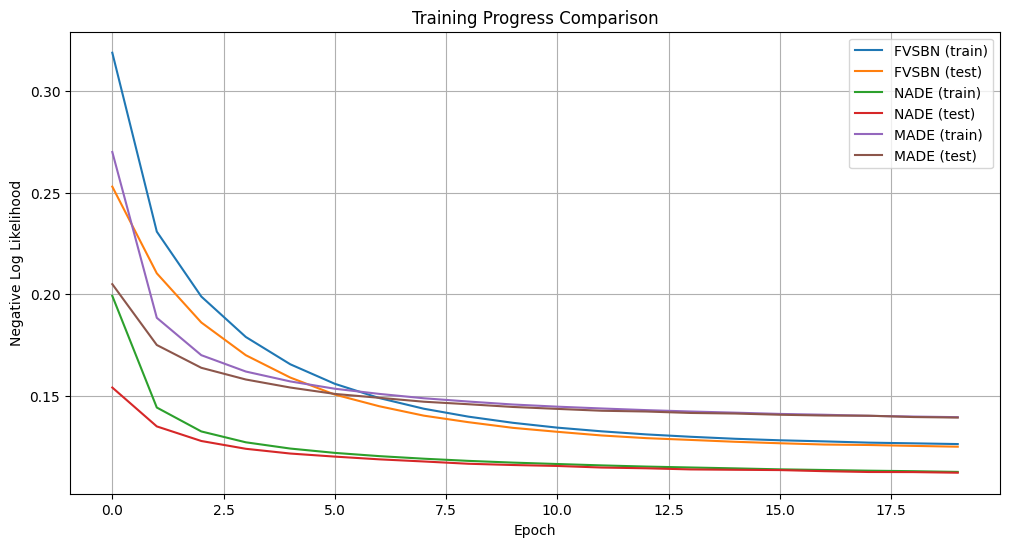

In [14]:
# Plot training curves
plt.figure(figsize=(12, 6))
plt.plot(fvsbn_train_losses, label='FVSBN (train)')
plt.plot(fvsbn_test_losses, label='FVSBN (test)')
plt.plot(nade_train_losses, label='NADE (train)')
plt.plot(nade_test_losses, label='NADE (test)')
plt.plot(made_train_losses, label='MADE (train)')
plt.plot(made_test_losses, label='MADE (test)')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.title('Training Progress Comparison')
plt.legend()
plt.grid(True)
plt.show()

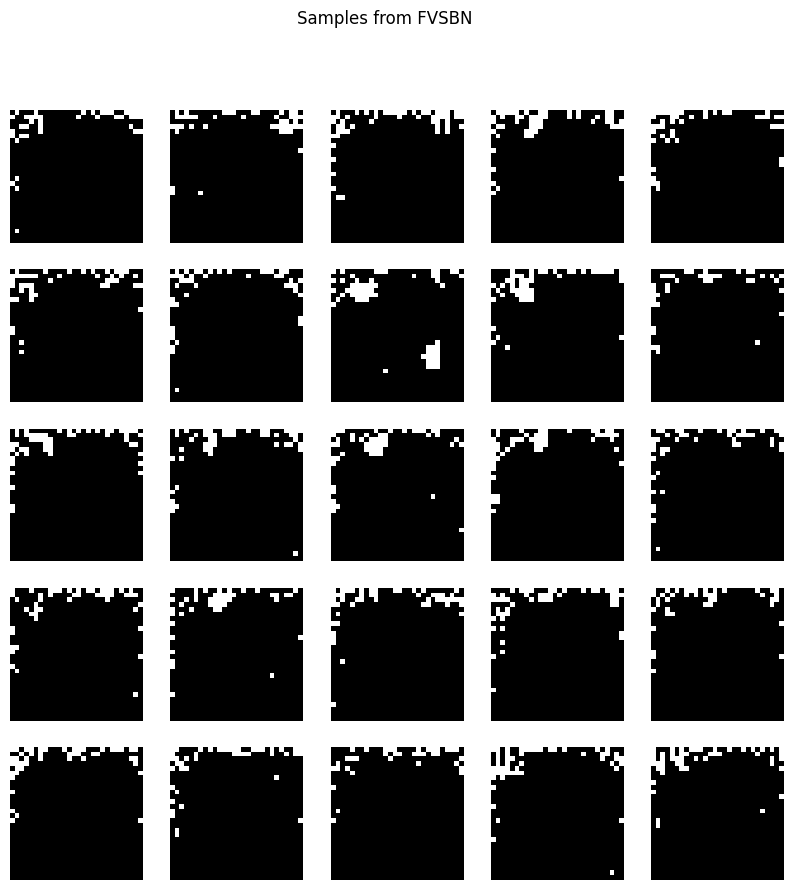

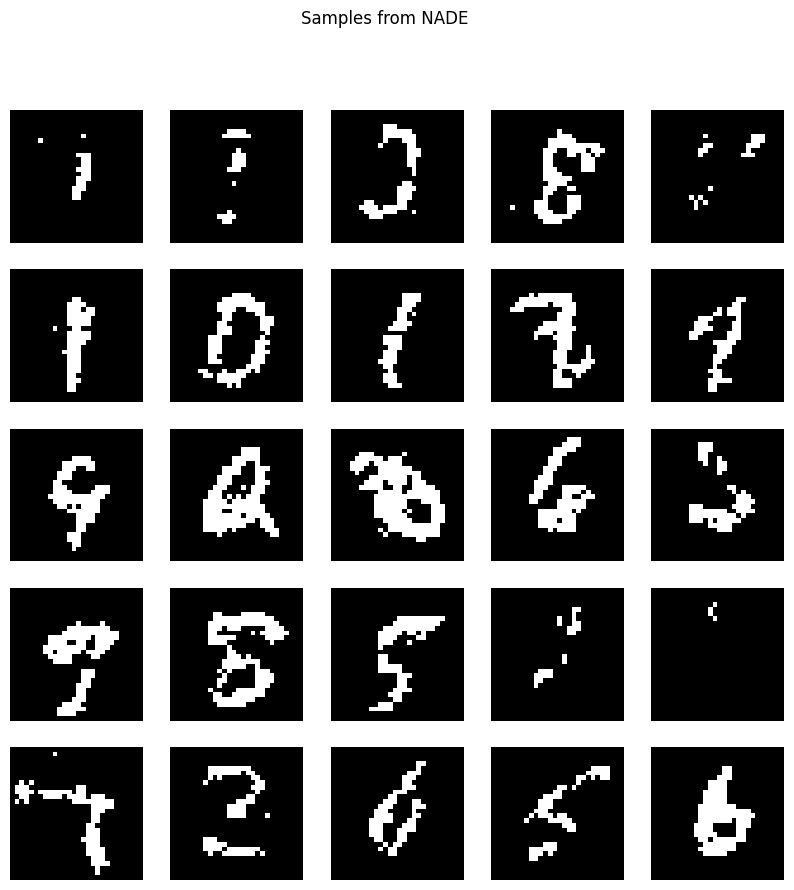

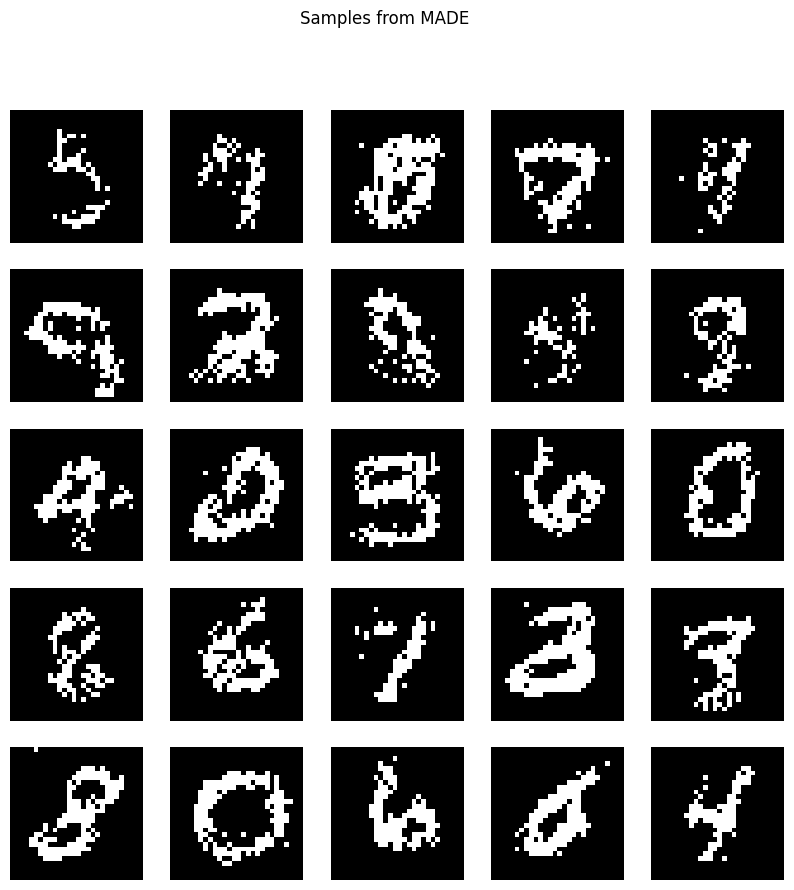

In [19]:
# Generate samples from each model
def plot_samples(model, title):
    with torch.no_grad():
        samples = model.sample(25)
        samples = samples.cpu().view(-1, 28, 28)
        
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Samples from {title}')
    plt.show()

plot_samples(fvsbn, 'FVSBN')
plot_samples(nade, 'NADE')
plot_samples(made, 'MADE')

| Model | Architecture | Pros | Cons | Best Use Cases |
|-------|-------------|------|------|----------------|
| FVSBN | - No hidden layers<br>- Direct connections between variables<br>- Uses sigmoid function for conditionals | - Fast to train<br>- Memory efficient<br>- Simple implementation | - Limited expressiveness<br>- Poor sample quality<br>- Struggles with complex patterns due to direct linear connections | - Baseline model<br>- Small binary datasets<br>- When interpretability is key |
| NADE | - Single hidden layer<br>- Shared weights across dimensions<br>- Hidden state of size 500 | - Better expressiveness than FVSBN<br>- Good balance of complexity/performance<br>- More stable training | - Sequential generation<br>- Slower than MADE<br>- Single hidden layer limitation | - Medium-sized binary data<br>- When balance between speed and quality is needed |
| MADE | - Multiple hidden layers (500, 500)<br>- Masked connections<br>- Deep architecture | - Best sample quality<br>- Can capture complex dependencies<br>- Faster than NADE despite depth | - Complex implementation<br>- More hyperparameters to tune<br>- Requires careful mask design | - Large binary datasets<br>- When sample quality is priority<br>- Production applications |

**Key Insights:**
1. The progression from FVSBN → NADE → MADE shows how adding neural network depth and sophisticated architectures improves generative modeling
2. FVSBN's poor performance stems from its inability to capture non-linear relationships between variables
3. NADE's shared weights and hidden layer allow it to learn more complex patterns while maintaining tractability
4. MADE's masked approach allows deep architectures while preserving autoregressive property, leading to best performance